<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/neural_decoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Standard Kalman Filter

---



In [ ]:
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler

class KalmanFilter(object):
    """
    Kalman Filter for neural decoding based on the Kording/Wu et al. 2003 framework.

    Adds support for using a fixed initial state (`z0`) and initial uncertainty (`P0`)
    computed from training data. This avoids dependence on ground-truth during inference.

    Attributes
    ----------
    C : float
        Scaling factor for process noise (W). Controls how much to trust the dynamics.

    model : dict
        Contains trained parameters:
            - A: State transition matrix
            - W: Process noise covariance
            - H: Observation matrix
            - Q: Observation noise covariance
            - z0: Initial state mean (column vector)
            - P0: Initial state covariance matrix
    """

    def __init__(self, C=1, O=1):
        """
        Initializes the Kalman filter object.

        Parameters
        ----------
        C : float, optional (default=1)
            Scaling factor for process noise (W). Increasing C reduces the weight of
            the dynamics (A) during filtering.
        O : int, optional (default=1)
            Autoregressive model order for the state model (must be >= 1). O controls how many past time steps are used to predict the next state. A larger O models long-term temporal dependencies.
        """
        self.C = C
        assert O >= 1, "Autoregressive order O must be >= 1"
        self.O = O

        self.data_preprocessor = StandardScaler() # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data

        self.used_PCA_TF = False # flag to tell predict() whether or not training used PCA

    def fit(self, X_train, y_train, use_PCA_TF=False, PC_thresh=None):
        """
        Train the Kalman Filter model using paired neural and behavioral data.

        Parameters
        ----------
        X_train : ndarray of shape [n_samples, n_neurons]
            Neural features (observations).
        use_PCA_TF : boolean scalar
            Transform neural data using PCA if true?
        PC_thresh : float or int scalar
            If int: Number of principal components to keep.
            If float: Proportion of variance to keep.
        y_train : ndarray of shape [n_samples, n_outputs]
            Behavioral variables (true hidden states).
        """

        # Run PCA if true
        if use_PCA_TF:
          self.used_PCA_TF = True
          self.num_PCs = None
          from sklearn.decomposition import PCA
          self.pca_transformer = PCA()
          self.pca_transformer.fit(X_train)

          if isinstance(PC_thresh,float) and PC_thresh>0:
              explained_var_cumsum = np.cumsum(self.pca_transformer.explained_variance_ratio_)
              self.num_PCs = np.where(explained_var_cumsum <= PC_thresh)[0][-1]
          elif isinstance(PC_thresh,int) and PC_thresh>0:
              self.num_PCs = PC_thresh

          X_train = self.pca_transformer.transform(X_train)[:, :self.num_PCs]

        # scale neural features
        X_train   = self.data_preprocessor.fit_transform(X_train)
        y_train   = self.targ_transformer.fit_transform(y_train)

        X  = np.matrix(y_train.T)  # Hidden state (e.g., kinematics)
        Z  = np.matrix(X_train.T)  # Observations (e.g., spikes)
        nt = X.shape[1]  # Number of time steps

        # Fit state transition matrix (A) and process noise (W)
        o = self.O  # autoregressive model order
        X2 = X[:, o:]
        X1 = X[:, 0:nt - o]
        A = X2 @ X1.T @ inv(X1 @ X1.T)
        W = (X2 - A @ X1) @ (X2 - A @ X1).T / (nt - o) / self.C

        # Fit observation matrix (H) and observation noise (Q)
        H = Z @ X.T @ inv(X @ X.T)
        Q = (Z - H @ X) @ (Z - H @ X).T / nt

        # Initial state: use first state from training
        z0 = np.asarray(X[:, 0]).flatten()  # Initial state vector

        # Initial uncertainty: small identity matrix
        P0 = np.eye(X.shape[0]) * 1e-3

        # Store model parameters
        self.model = {
            'A': A,
            'W': W,
            'H': H,
            'Q': Q,
            'z0': z0,
            'P0': P0
        }

    def predict(self, X_pred):
        """
        Predict hidden states from neural observations using the trained Kalman Filter.

        This method initializes the filter with the precomputed `z0` and `P0` from training.

        Parameters
        ----------
        X_pred : ndarray of shape [n_samples, n_neurons]
            Neural features to decode.

        Returns
        -------
        y_pred : ndarray of shape [n_samples, n_outputs]
            Estimated hidden states (e.g., positions or velocities).
        """

        if self.used_PCA_TF:
          X_pred = self.pca_transformer.transform(X_pred)[:, :self.num_PCs]

        X_pred = self.data_preprocessor.transform(X_pred)

        # Load model parameters
        A = self.model['A']
        W = self.model['W']
        H = self.model['H']
        Q = self.model['Q']
        z0 = self.model['z0']
        P0 = self.model['P0']

        Z = np.matrix(X_pred.T)
        num_states = A.shape[0]
        num_timesteps = Z.shape[1]

        # Initialize state and covariance
        states = np.empty((num_states, num_timesteps))
        P = np.matrix(P0)
        state = np.matrix(z0).T  # Ensure column vector

        # Set initial state
        states[:, 0] = np.asarray(state).flatten()

        # Kalman filtering loop
        for t in range(num_timesteps - 1):
            # Predict next state
            P_m = A @ P @ A.T + W
            state_m = A @ state

            # Kalman gain
            K = P_m @ H.T @ np.linalg.inv(H @ P_m @ H.T + Q)

            # Update state
            state = state_m + K @ (Z[:, t + 1] - H @ state_m)
            P = (np.eye(num_states) - K @ H) @ P_m

            # Store prediction
            states[:, t + 1] = np.asarray(state).flatten()

        # ----------- Aliases -----------
        # H is sometimes denoted as C in literature, and represents the transformation that converts kinematics to neural features
        # Z is sometimes denoted y and represents the observed neural features
        # -------------------------------

        # Return predicted states (time x features)...after undoing zero-centering
        return self.targ_transformer.inverse_transform(states.T)


### ReFIT-Kalman Filter

---





In [ ]:
import numpy as np
from numpy.linalg import inv

class ReFITKalmanFilter(KalmanFilter):
    """
    ReFIT Kalman Filter (Gilja et al., 2012) using intention-aligned training and optional
    position feedback correction during decoding.

    This subclass extends KalmanFilter_zeroInit by:

    1. Modifying the training targets to reflect intended velocities based on position and target.
    2. Supporting velocity reorientation methods: "flip", "rotate", or "both".
    3. Allowing optional velocity zeroing when inside the target.

    Parameters
    ----------
    C : float
        Scaling factor for process noise in KalmanFilter_zeroInit.
    alpha : float
        Velocity blending factor during training (used for rotation).
    velocity_rot_method : str
        Velocity correction method: 'flip', 'rotate', or 'both'.
    zero_vel_on_target_TF : bool
        If True, zero velocity when inside target radius.
    """
    def __init__(self, C=1, alpha=0.8, velocity_rot_method="flip", zero_vel_on_target_TF=False):
        super().__init__(C)
        self.alpha = alpha
        self.velocity_rot_method = velocity_rot_method.lower()
        self.zero_vel_on_target_TF = zero_vel_on_target_TF

    def _compute_flipped_velocity(self, pos, vel, targ, targsize):
        """Flip velocity if moving away from the target."""
        v_flip = vel.copy()
        T, D = pos.shape
        for t in range(T):
            for d in range(D):
                if targ[t, d] == -1:
                    continue
                dist = pos[t, d] - targ[t, d]
                hit = abs(dist) < targsize
                if self.zero_vel_on_target_TF and hit:
                    v_flip[t, d] = 0
                elif (dist < 0 and v_flip[t, d] < 0) or (dist > 0 and v_flip[t, d] > 0):
                    v_flip[t, d] *= -1
        return v_flip

    def _compute_rotated_velocity(self, pos, vel, targ, targsize):
        """Rotate velocity to point toward the target direction."""
        v_rot = vel.copy()
        T, D = pos.shape
        targ = targ[:, :D]  # Only keep position dimensions

        for t in range(T):
            good_dims = targ[t] != -1
            if not np.any(good_dims):
                continue
            vec_to_target = targ[t, good_dims] - pos[t, good_dims]
            norm_vec = np.linalg.norm(vec_to_target)
            if norm_vec > 1e-5:
                speed = np.linalg.norm(v_rot[t, good_dims])
                v_rot[t, good_dims] = (vec_to_target / norm_vec) * speed
                if self.zero_vel_on_target_TF:
                    hit_mask = np.zeros_like(good_dims)
                    hit_mask[good_dims] = np.abs(pos[t, good_dims] - targ[t, good_dims]) < targsize
                    v_rot[t, hit_mask] = 0
        return v_rot

    def compute_intended_trajectory(self, y_train, targets, targsize):
        """
        Modifies training trajectories to align velocity with target using selected strategy.

        Parameters
        ----------
        y_train : ndarray of shape [T, 2*D]
            Original training behavior data [position, velocity].
        targets : ndarray of shape [T, D]
            Target positions.
        targsize : scalar
            Target size threshold for each time point.

        Returns
        -------
        y_refit : ndarray of shape [T, 2*D]
            Modified training data with position and reoriented velocity.
        """
        T, total_dims = y_train.shape
        D = total_dims // 2
        pos = y_train[:, :D]
        vel = y_train[:, D:]

        if self.velocity_rot_method == "rotate":
            vel_new = self._compute_rotated_velocity(pos, vel, targets, targsize)
            pos_new = pos
        elif self.velocity_rot_method == "flip":
            vel_new = self._compute_flipped_velocity(pos, vel, targets, targsize)
            pos_new = pos

        else:
            raise ValueError("Invalid velocity_rot_method. Must be 'flip' or 'rotate'.")

        return np.hstack([pos_new, vel_new])

    def fit(self, X_kf_train, y_train, targets=None, targsize=None):
        """
        Fits the Kalman Filter using intention-aligned trajectories if targets and targsize are given.

        Parameters
        ----------
        X_kf_train : ndarray
            Neural input data.
        y_train : ndarray
            Original behavioral training data [position, velocity].
        targets : ndarray, optional
            Target positions corresponding to each training time step.
        targsize : ndarray, optional
            Target radius threshold for each time step.
        """
        if targets is not None and targsize is not None:
            y_train_rotated = self.compute_intended_trajectory(y_train, targets, targsize)
        super().fit(X_kf_train, y_train_rotated)

    def predict(self, X_kf_test, position_feedback=None):
        """
        Decodes neural data and optionally replaces predicted position with known position feedback.

        Parameters
        ----------
        X_kf_test : ndarray
            Neural test data.
        position_feedback : ndarray, optional
            Known position data to replace decoded positions.

        Returns
        -------
        states : ndarray
            Decoded behavioral states.
        """
        states = super().predict(X_kf_test)
        if position_feedback is not None:
            states[:, :position_feedback.shape[1]] = position_feedback
        return states


In [ ]:

def _compute_rotated_velocity(pos, vel, targ, targsize):
  """Rotate velocity to point toward the target direction."""
  v_rot = vel.copy()
  T, D = pos.shape
  targ = targ[:, :D]  # Only keep position dimensions

  for t in range(T):
      good_dims = targ[t] != -1
      if not np.any(good_dims):
          continue
      vec_to_target = targ[t, good_dims] - pos[t, good_dims]
      norm_vec = np.linalg.norm(vec_to_target)
      if norm_vec > 1e-5:
          speed = np.linalg.norm(v_rot[t, good_dims])
          v_rot[t, good_dims] = (vec_to_target / norm_vec) * speed

          hit_mask = np.zeros_like(good_dims)
          hit_mask[good_dims] = np.abs(pos[t, good_dims] - targ[t, good_dims]) < targsize
          v_rot[t, hit_mask] = 0
  return v_rot


In [ ]:
T, total_dims = targ.shape
D = total_dims // 2
pos = targ[:, :D]
vel = targ[:, D:]

vel_new = _compute_rotated_velocity(pos, vel, targ_feedback, 0.75)


In [ ]:
import numpy as np

def rotate_towards(y_pred_feedback, y_targ):
    direction = y_targ / np.linalg.norm(y_targ)  # unit vector in direction of target
    magnitude = np.linalg.norm(y_pred_feedback)
    return magnitude * direction
targ_new = rotate_towards(targ_feedback[:,1],targ[:,1])

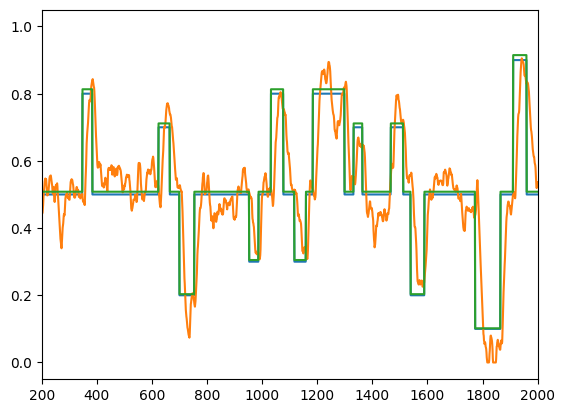

In [ ]:
plt.plot(targ[:,1])
plt.plot(targ_feedback[:,1])
plt.plot(targ_new)
plt.xlim(200,2000)
plt.show()

### Wiener Filter (Unregularized Linear Regression)

---



In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

class WienerFilterDecoder(object):

    """
    Class for the Wiener Filter Decoder

    There are no parameters to set.

    This simply leverages the scikit-learn linear regression.
    """

    def __init__(self):
        self.data_preprocessor = StandardScaler() # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data
        self.model = LinearRegression()

    def fit(self,X_train,y_train,num_bins_before=3):

        """
        Train Wiener Filter Decoder

        Parameters
        ----------
        X_train: numpy 2d array of shape [n_samples,n_features]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """
        # ---------------- Preprocess Training Data --------------
        self.num_bins_before = num_bins_before

        # Get the covariate matrix that includes spike history from previous bins
        X_train, y_train = append_history(X_train, targ_data=y_train,num_bins_before = num_bins_before)

        X_train = self.data_preprocessor.fit_transform(X_train)
        y_train = self.targ_transformer.fit_transform(y_train)

        #----------------------------------------------------------
        self.model.fit(X_train, y_train) #Train the model


    def predict(self,X_pred):

        """
        Predict outcomes using trained Wiener Cascade Decoder

        Parameters
        ----------
        X_pred: numpy 2d array of shape [n_samples,n_features]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_pred: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """
        # ----------- Preprocess Test (Prediction) Data -------------
        num_bins_before = self.num_bins_before

        # Get the covariate matrix that includes spike history from previous bins
        X_pred,_ = append_history(X_pred, num_bins_before = num_bins_before)

        X_pred = self.data_preprocessor.transform(X_pred) # Z-score neural data

        # ------------------------------------------------------------
        y_pred = self.model.predict(X_pred) # Make predictions

        y_pred = self.targ_transformer.inverse_transform(y_pred) # Undo zero-centering

        return y_pred


### Ridge Regression Decoder

---



In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import numpy as np

class RidgeDecoder(object):
    """
    Ridge Regression-based Decoder.

    Includes history stacking and standardization of input features (Z-scoring) and
    zero-centering of targets.
    """

    def __init__(self, alpha=1.0):
        """
        Parameters
        ----------
        alpha : float
            Regularization strength for Ridge regression.
        """
        self.alpha = alpha
        self.data_preprocessor = StandardScaler()  # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False)  # Zero-center target
        self.model = Ridge(alpha=self.alpha, max_iter=10000)

    def fit(self, X_train, y_train, num_bins_before=3):
        """
        Train the Ridge Wiener Filter decoder.

        Parameters
        ----------
        X_train : ndarray, shape (n_samples, n_features)
            Neural activity data.

        y_train : ndarray, shape (n_samples, n_outputs)
            Target output data (e.g., cursor velocity).

        num_bins_before : int
            Number of history bins to include before the current bin.
        """
        self.num_bins_before = num_bins_before

        # Create history-augmented neural data
        X_train_hist, y_train_trimmed = append_history(X_train, y_train, num_bins_before)

        # Standardize input and target data
        X_train_scaled   = self.data_preprocessor.fit_transform(X_train_hist)
        y_train_centered = self.targ_transformer.fit_transform(y_train_trimmed)

        # Train Ridge regression model
        self.model.fit(X_train_scaled, y_train_centered)

    def predict(self, X_pred):
        """
        Predict output using trained decoder.

        Parameters
        ----------
        X_pred : ndarray, shape (n_samples, n_features)
            Neural activity data for prediction.

        Returns
        -------
        y_pred : ndarray, shape (n_samples - num_bins_before, n_outputs)
            Predicted target outputs.
        """
        num_bins_before = self.num_bins_before

        # Apply same history transformation and scaling
        X_pred_hist, _ = append_history(X_pred, None, num_bins_before)
        X_pred_scaled  = self.data_preprocessor.transform(X_pred_hist)

        # Predict and un-center the predictions
        y_pred_centered = self.model.predict(X_pred_scaled)
        y_pred = self.targ_transformer.inverse_transform(y_pred_centered)

        return y_pred


### Ensemble Learner (XGBoost)

---



In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

class XGBoostMultiOutputDecoder(BaseEstimator, RegressorMixin):
    """
    XGBoost-based decoder for multidimensional regression using a single model,
    with support for input history stacking, optional validation data, and early stopping.

    Parameters
    ----------
    max_depth : int
        Maximum depth of trees.
    num_round : int
        Maximum number of boosting rounds.
    eta : float
        Learning rate.
    num_bins_before : int
        Number of past bins to include as time history.
    patience : int or None
        If set, enables early stopping with validation set (after patience rounds of no performance improvement).
    """

    def __init__(self, max_depth=3, num_round=300, eta=0.3, min_child_weight=2, subsample = 0.5, colsample_bytree=0.8, num_bins_before=3, patience=10,val_verbose=False):
        self.max_depth = max_depth
        self.num_round = num_round
        self.eta = eta
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.num_bins_before = num_bins_before
        self.patience = patience
        self.val_verbose = val_verbose

        self.model = None
        self.data_preprocessor = StandardScaler()
        self.target_centerer = StandardScaler(with_std=False)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Fit model with optional validation for early stopping.

        Parameters
        ----------
        X : ndarray, shape (T, N)
            Training neural features.

        y : ndarray, shape (T, D)
            Training targets.

        X_val : ndarray, optional
            Validation neural features.

        y_val : ndarray, optional
            Validation targets.
        """
        X_train_hist, y_train_hist = append_history(X, y, self.num_bins_before)
        X_train_scaled = self.data_preprocessor.fit_transform(X_train_hist)
        y_train_centered = self.target_centerer.fit_transform(y_train_hist)

        dtrain = xgb.DMatrix(X_train_scaled, label=y_train_centered)

        evals = []
        evals_result = {}

        if X_val is not None and y_val is not None:
            X_val_hist, y_val_hist = append_history(X_val, y_val, self.num_bins_before)
            X_val_scaled = self.data_preprocessor.transform(X_val_hist)
            y_val_centered = self.target_centerer.transform(y_val_hist)

            dval = xgb.DMatrix(X_val_scaled, label=y_val_centered)
            evals = [(dtrain, "train"), (dval, "val")]
        else:
            evals = [(dtrain, "train")]

        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': self.max_depth,
            'eta': self.eta,
            'min_child_weight': self.min_child_weight,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'verbosity': 0}

        self.model = xgb.train(
            params,
            dtrain,
            num_boost_round=self.num_round,
            evals=evals,
            evals_result=evals_result,
            early_stopping_rounds=self.patience if len(evals) > 1 else None,
            verbose_eval=self.val_verbose
        )

        return self

    def predict(self, X):
        """
        Predict from neural data.

        Parameters
        ----------
        X : ndarray, shape (T, N)
            Neural input.

        Returns
        -------
        y_pred : ndarray, shape (T - num_bins_before, D)
            Predicted targets.
        """
        X_hist, _ = append_history(X, None, self.num_bins_before)
        X_scaled = self.data_preprocessor.transform(X_hist)
        dtest = xgb.DMatrix(X_scaled)

        y_pred_centered = self.model.predict(dtest)
        y_pred = self.target_centerer.inverse_transform(y_pred_centered)
        return y_pred


### Feed Forward Neural Network

---



In [ ]:

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

import numpy as np

class FeedForwardNNDecoder(object):

    """
    Class for the dense (fully-connected) neural network decoder

    Parameters
    ----------

    units: integer or vector of integers, optional, default 400
        This is the number of hidden units in each layer
        If you want a single layer, input an integer (e.g. units=400 will give you a single hidden layer with 400 units)
        If you want multiple layers, input a vector (e.g. units=[400,200]) will give you 2 hidden layers with 400 and 200 units, repsectively.
        The vector can either be a list or an array

    dropout: decimal, optional, default 0
        Proportion of units that get dropped out

    num_epochs: integer, optional, default 10
        Number of epochs used for training

    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=64, dropout=0.25, batch_size=32, num_epochs=100, verbose=1):
         self.dropout    = dropout
         self.num_epochs = num_epochs
         self.batch_size = batch_size
         self.verbose    = verbose

         self.num_bins_before = None

         #If "units" is an integer, put it in the form of a vector
         try: #Check if it's a vector
             units[0]
         except: #If it's not a vector, create a vector of the number of units for each layer
             units=[units]
         self.units=units

         #Determine the number of hidden layers (based on "units" that the user entered)
         self.num_layers=len(units)

         self.data_preprocessor = StandardScaler() # Z-score neural data
         self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data


    def fit(self,X_train,y_train, val_data = None, num_bins_before=3, early_stopping_TF = True, patience = 20):

        """
        Train DenseNN Decoder

        Parameters
        ----------
        X_train: numpy 2d array of shape [n_samples,n_features]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """
        # ---------------- Preprocess Training Data --------------
        self.num_bins_before = num_bins_before
        # Get the covariate matrix that includes spike history from previous bins
        X_train, y_train = append_history(X_train, targ_data = y_train, num_bins_before = num_bins_before)

        X_train = self.data_preprocessor.fit_transform(X_train)
        y_train = self.targ_transformer.fit_transform(y_train)

        # ----------- Preprocess Validation Data, if Available -----------

        callbacks = []
        # preprocess validation set
        if val_data is not None:
          val_data[0] = append_history(val_data[0], num_bins_before = num_bins_before)
          val_data[0] = val_data[0].reshape(val_data[0].shape[0], -1)
          val_data[0] = val_data[0][num_bins_before:,:]
          val_data[0] = self.data_preprocessor.fit_transform(val_data[0])

          val_data[1] = val_data[1][num_bins_before:,:]
          val_data[1] = self.targ_transformer.fit_transform(val_data[1])

          if early_stopping_TF:
            from keras.callbacks import EarlyStopping
            early_stop = EarlyStopping(monitor   = 'val_loss',
                                        patience = patience,
                                        restore_best_weights=True,
                                        verbose=0)
            callbacks.append(early_stop)

        model=Sequential() #Declare model
        #Add first hidden layer
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(self.units[0])) #Add dense layer
        model.add(Activation('relu')) #Add nonlinear (tanh) activation
        # if self.dropout!=0:
        if self.dropout!=0: model.add(Dropout(self.dropout))  #Dropout some units if proportion of dropout != 0

        #Add any additional hidden layers (beyond the 1st)
        for layer in range(self.num_layers-1): #Loop through additional layers
            model.add(Dense(self.units[layer+1])) #Add dense layer
            model.add(Activation('relu')) #Add nonlinear (tanh) activation
            if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units if proportion of dropout != 0

        #Add dense connections to all outputs
        model.add(Dense(y_train.shape[1])) #Add final dense layer (connected to outputs)

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer=Adam(learning_rate=1e-4),metrics=['mse']) #Set loss function and optimizer

        model.fit(X_train,
                  y_train,epochs = self.num_epochs,
                  batch_size     = self.batch_size,
                  validation_data= val_data,
                  callbacks      = callbacks,
                  verbose        = self.verbose) #Fit the model

        self.model=model

    def predict(self,X_pred):

        """
        Predict outcomes using trained DenseNN Decoder

        Parameters
        ----------
        X_pred: numpy 2d array of shape [n_samples,n_features]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_pred: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        # ----------- Preprocess Test (Prediction) Data -------------
        num_bins_before = self.num_bins_before

        # Get the covariate matrix that includes spike history from previous bins
        X_pred, _ = append_history(X_pred, num_bins_before = num_bins_before)

        X_pred = self.data_preprocessor.transform(X_pred) #Z-score neural data

        # ------------------------------------------------------------
        y_pred = self.model.predict(X_pred) # Make predictions

        y_pred = self.targ_transformer.inverse_transform(y_pred) #Undo zero-centering
        return y_pred



### CNN-FeedForward Hybrid Neural Network

---



In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import (Input, BatchNormalization, Conv1D, Dense,
                                     Dropout, Flatten, Permute, ReLU)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class CNN_FeedForwardNNDecoder:
    """
    CNN + Feedforward Neural Network decoder with built-in history stacking.

    This model accepts raw neural data of shape (T, N), appends a time window of
    past activity, and uses a combination of 1D convolution and dense layers for regression.

    Parameters
    ----------
    hidden_size : int
        Number of units in each fully connected layer.
    ConvSizeOut : int
        Number of filters in the Conv1D layer.
    num_outputs : int
        Number of continuous regression outputs.
    learning_rate : float, default=1e-3
        Optimizer learning rate.
    dropout_rate : float, default=0.5
        Dropout rate for regularization.
    num_bins_before : int, default=3
        Number of history bins to include before the current bin.
    """

    def __init__(self, hidden_size=256, ConvSizeOut=16,
                 learning_rate=1e-3, dropout_rate=0, num_bins_before=3):
        self.hidden_size     = hidden_size
        self.ConvSizeOut     = ConvSizeOut
        self.learning_rate   = learning_rate
        self.dropout_rate    = dropout_rate
        self.num_bins_before = num_bins_before

        self.model       = None
        self.input_size  = None
        self.num_outputs = None

        self.used_PCA_TF = False # flag to tell predict() whether or not PCA was used during training

        self.data_preprocessor = StandardScaler() # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data


    def _build_model(self, input_size, num_outputs):
        """
        Build the internal Keras model after inferring input/output dimensions.

        Parameters
        ----------
        input_size : int
        num_outputs : int

        Returns
        -------
        model : tf.keras.Model
        """
        input_tensor = Input(shape=(self.num_bins_before + 1, input_size), name='Input')
        x = BatchNormalization(name='BN0')(input_tensor)
        x = Permute((2, 1), name='Permute')(x)  # (batch, channels, time)
        x = Conv1D(filters=self.ConvSizeOut, kernel_size=1, name='Conv1')(x)
        x = Flatten(name='Flatten')(x)

        for i in range(3):
            x = Dense(self.hidden_size, kernel_initializer='he_normal', name=f'FC{i+1}')(x)
            x = Dropout(self.dropout_rate, name=f'Dropout{i+1}')(x)
            x = BatchNormalization(name=f'BN{i+2}')(x)
            x = ReLU(name=f'ReLU{i+1}')(x)

        output = Dense(num_outputs, kernel_initializer='he_normal', name='Output')(x)
        model = Model(inputs=input_tensor, outputs=output, name='CNN_FeedForwardNNDecoder')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mean_squared_error',
            metrics=['mae']
        )
        return model


    def fit(self, X_train, y_train, use_PCA_TF=False, PC_thresh=None, batch_size=32, epochs=10,
            validation_data = None, verbose  = 1,
            early_stopping  = True, patience = 5, checkpoint_path = None):
        """
        Fit the model using raw neural and target data.

        Parameters
        ----------
        X_train : ndarray, shape (T, N)
            Raw training neural data.
        y_train : ndarray, shape (T, D)
            Training regression targets.
        validation_data : tuple or None
            Tuple of (X_val, y_val), both raw.
        early_stopping : bool, default=True
            Whether to use early stopping.
        patience : int, default=5
            Number of epochs to wait before stopping.
        checkpoint_path : str or None
            If given, saves best model weights to this path.
        """

        #------- Run PCA if true ------------
        if use_PCA_TF:
          self.used_PCA_TF = True
          self.num_PCs = None
          from sklearn.decomposition import PCA
          self.pca_transformer = PCA()
          self.pca_transformer.fit(X_train)

          if isinstance(PC_thresh,float) and PC_thresh>0:
              explained_var_cumsum = np.cumsum(self.pca_transformer.explained_variance_ratio_)
              self.num_PCs = np.where(explained_var_cumsum <= PC_thresh)[0][-1]
          elif isinstance(PC_thresh,int) and PC_thresh>0:
              self.num_PCs = PC_thresh

          X_train = self.pca_transformer.transform(X_train)[:, :self.num_PCs]

        # ---------- scale neural features ---------------
        X_train   = self.data_preprocessor.fit_transform(X_train)
        y_train   = self.targ_transformer.fit_transform(y_train)

        # ------------- Append history and infer shapes --------------
        X_hist, y_hist = append_history_cnn(X_train, y_train, self.num_bins_before)

        # if self.model is None:
        #     self.input_size  = X_hist.shape[2]
        #     self.num_outputs = y_hist.shape[1]
        #     self.model = self._build_model(self.input_size, self.num_outputs)
        self.input_size  = X_hist.shape[2]
        self.num_outputs = y_hist.shape[1]
        self.model = self._build_model(self.input_size, self.num_outputs)

        # Handle validation data
        val_data = None
        if validation_data is not None:
            X_val, y_val = validation_data

            if self.used_PCA_TF:
              X_val = self.pca_transformer.transform(X_val)[:, :self.num_PCs]

            X_val = self.data_preprocessor.transform(X_val)
            y_val = self.targ_transformer.transform(y_val)

            X_val_hist, y_val_hist = append_history_cnn(X_val, y_val, self.num_bins_before)
            val_data = (X_val_hist, y_val_hist)

        # Setup callbacks
        callbacks = []
        if early_stopping and val_data:
            callbacks.append(EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True))
        if checkpoint_path:
            callbacks.append(ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'))

        return self.model.fit(
            X_hist, y_hist,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=val_data,
            callbacks=callbacks,
            verbose=verbose
        )

    def predict(self, X_pred):
        """
        Predict using the trained model from raw neural input.

        Parameters
        ----------
        X_pred : ndarray, shape (T, N)
            Raw neural data.

        Returns
        -------
        y_pred : ndarray, shape (T - num_bins_before, D)
            Predicted target values.
        """

        if self.used_PCA_TF:
          X_pred = self.pca_transformer.transform(X_pred)[:, :self.num_PCs]

        X_pred = self.data_preprocessor.transform(X_pred)

        X_hist, _ = append_history_cnn(X_pred, None, self.num_bins_before)
        y_pred = self.model.predict(X_hist)
        y_pred = self.targ_transformer.inverse_transform(y_pred)
        return y_pred

    def summary(self):
        """Print the model architecture summary."""
        return self.model.summary()

    def save(self, path):
        """
        Save the full model to a file.

        Parameters
        ----------
        path : str
            Path to save the model (e.g., 'model.h5')
        """
        self.model.save(path)

    def load_weights(self, path):
        """
        Load weights from a checkpoint file.

        Parameters
        ----------
        path : str
            Path to weights file (e.g., 'best_weights.h5')
        """
        self.model.load_weights(path)
